### Valeria Rebagliati 4852454
#### dataset 12: movimenti


# Introduzione

Vengono forniti due dataset, il primo position che rappresenta i muovimenti e le cordinate degli spostamenti nel tempo, il secondo feature, che associa al primo varie feature per ogni azione; le feature danno informazioni sulle azioni dividendosi in tre macro-gruppi che sono: displacement, frequency, dynamic.
Per ogni azione svolta da un certo individuo (in totale 16 persone) vengono raccolti 2 video. Per tracciare l'azione vengono presi dei riferimenti nel corpo che chiameremo giunti e sono: occhi, naso, orecchie, spalle, gomiti e polsi.

# Obiettivi

Confronterò azioni simili rispetto alle loro proprietà cinematiche ovvero usando le propietà di:
- spostamento
- velocità
- accelerazione 
- derivate delle precedenti


Per quanto riguarda i gruppi di azioni abbiamo quindi:
* trasporto - tocco (di cubo di rubik e bottiglia)
* bere - mangiare patatine 
* lavarsi le mani - aprire una bottiglia - giocare con il cubo di rubik


In [1]:
import pandas as pd
import numpy as np
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import sklearn 


from sklearn import preprocessing
from sklearn.cluster import KMeans

import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn import decomposition


In [2]:
positions_3d = "positions_3d.csv"
features = "features.parquet.gz"

In [3]:
#versione di sklearn utilizzata
print(sklearn.__version__)
#%pip install -U scikit-learn

1.1.1


In [4]:
positions_df = pd.read_csv(positions_3d, header=[0, 1], index_col=[0, 1, 2, 3]).astype(np.float16)

### Esplorazione
Vediamo informazioni di base relative al dataset position

In [5]:
positions_df.head()

joint                              lear                 lelbow           \
variable                              x       y       z      x        y   
individual action   sample frame                                          
0          drinking 0      0      514.5 -355.50  2058.0  626.0  134.000   
                           1      515.0 -357.50  2060.0  626.0  134.000   
                           2      515.0 -357.50  2060.0  626.0  134.000   
                           3      515.0 -357.50  2060.0  626.0  134.000   
                           4      515.5 -359.75  2062.0  628.5  134.125   

joint                                       leye                 lshoulder  \
variable                               z       x       y       z         x   
individual action   sample frame                                             
0          drinking 0      0      1706.0  467.50 -369.00  2064.0     568.0   
                           1      1706.0  467.75 -371.00  2066.0     565.5   
                           2      1706.0  466.00 -373.25  2066.0     565.5   
                           3      1706.0  466.00 -373.25  2066.0     565.5   
                           4      1707.0  466.00 -373.25  2066.0     565.5   

joint                             ...  relbow    reye                  \
variable                          ...       z       x       y       z   
individual action   sample frame  ...                                   
0          drinking 0      0      ...  1678.0  366.50 -374.75  2070.0   
                           1      ...  1682.0  366.75 -377.00  2072.0   
                           2      ...  1682.0  366.75 -377.00  2072.0   
                           3      ...  1682.0  367.00 -379.25  2074.0   
                           4      ...  1682.0  367.00 -379.25  2074.0   

joint                            rshoulder                     rwrist          \
variable                                 x        y       z         x       y   
individual action   sample frame                                                
0          drinking 0      0       128.750 -72.9375  1891.0  42.84375  200.75   
                           1       128.875 -74.8750  1892.0  41.43750  200.00   
                           2       128.875 -74.8750  1892.0  41.43750  200.00   
                           3       128.875 -74.8750  1892.0  41.43750  200.00   
                           4       128.875 -74.8750  1892.0  41.43750  200.00   

joint                                     
variable                               z  
individual action   sample frame          
0          drinking 0      0      1469.0  
                           1      1473.0  
                           2      1473.0  
                           3      1473.0  
                           4      1473.0  

[5 rows x 33 columns]

In [6]:
positions_df.shape

(59941, 33)

In [7]:
positions_df.dtypes

joint      variable
lear       x           float16
           y           float16
           z           float16
lelbow     x           float16
           y           float16
           z           float16
leye       x           float16
           y           float16
           z           float16
lshoulder  x           float16
           y           float16
           z           float16
lwrist     x           float16
           y           float16
           z           float16
nose       x           float16
           y           float16
           z           float16
rear       x           float16
           y           float16
           z           float16
relbow     x           float16
           y           float16
           z           float16
reye       x           float16
           y           float16
           z           float16
rshoulder  x           float16
           y           float16
           z           float16
rwrist     x           float16
           y       

**Livelli del dataset**

In [8]:
for i in range(positions_df.index.nlevels):
    index = positions_df.index.get_level_values(i).unique()
    print(index.name, ":", index, "\n")

individual : Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name='individual') 

action : Index(['drinking', 'eat_crisp', 'open_close_bottle', 'rubiks_cube', 'sanitise',
       'touch_bottle', 'touch_rubiks_cube', 'transport_bottle',
       'transport_pen', 'transport_rubiks_cube'],
      dtype='object', name='action') 

sample : Int64Index([0, 1, 2], dtype='int64', name='sample') 

frame : Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            459, 460, 461, 462, 463, 464, 465, 466, 467, 468],
           dtype='int64', name='frame', length=469) 



In [9]:
for i in range(positions_df.columns.nlevels):
    col = positions_df.columns.get_level_values(i).unique()
    print(col.name, ":", col, "\n")

joint : Index(['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear',
       'relbow', 'reye', 'rshoulder', 'rwrist'],
      dtype='object', name='joint') 

variable : Index(['x', 'y', 'z'], dtype='object', name='variable') 



### Visualizzazione
Per avere un punto di partenza nell'analisi dei dati parto con la visualizzazione dei movimenti, attingendo dal primo dataset fornito, **posistion**; in questo modo sarà possibile formulare delle ipotesi su cui costruire test successivi.

Per farlo ho costruito la funzione di seguito che, data un'azione, una lista di giunti e una persona restituirà il grafico del movimento dei giunti di quella persona mentre svolge quella determinata azione.
In questo modo potremmo visualizzare il muovimento nello spazio con la traiettoria dei vari giunti.

In [10]:
def plot_action(action, joints, pearson):
    
    fig = plt.figure()
 
    ax = plt.axes(projection ='3d')
    
    #rotazione di 180 rispetto a y e 180 rispetto a x
    ax.view_init(90,90)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    for i in range(0, len(joints)):
        
        z = positions_df.loc[idx[ pearson, action, 0, :], idx[joints[i], "z"]]
        x = positions_df.loc[idx[ pearson, action, 0, :], idx[joints[i], "x"]]
        y = positions_df.loc[idx[ pearson, action, 0, :], idx[joints[i], "y"]]

        ax.plot3D(x, y, z)

    plt.show()
    


Prima di vedere i grafici, posso fare delle supposizioni su quello che vedrò:
* i movimenti di tutte le componenti del viso per qualsiasi azione, saranno uguali ma con shift diversi, come i movimenti delle spalle, perchè stanno sullo stesso asse
* i movimenti presi dai giunti delle braccia saranno meno "rigidi" e indipendenti rispetto a quelli sopra
* le varie azioni di trasporto avranno movimenti simili
* le varie azioni di tocco avranno movimenti simili

Per completezza nella rappresentazione prenderò tutti i giunti per chiarire il movimento generale.

Parto con la visualizzazione di trasporto bottiglia e a seguire tocco bottiglia:

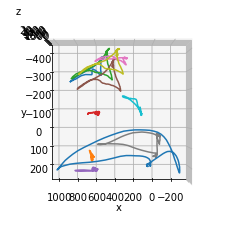

In [11]:
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear', 'relbow', 'reye', 'rshoulder', 'rwrist']

action = "transport_bottle"
plot_action(action,joints,0)

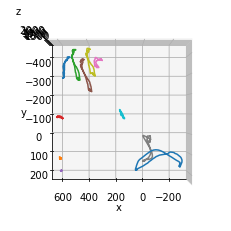

In [12]:
action = "touch_bottle"
plot_action(action, joints, 0)

Trasporto e tocco del cubo di rubik:

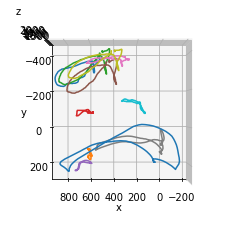

In [13]:
action = "transport_rubiks_cube"
plot_action(action,joints,0)

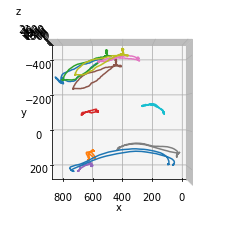

In [14]:
action = "touch_rubiks_cube"
plot_action(action, joints, 0)

Bere e mangiare patatine:

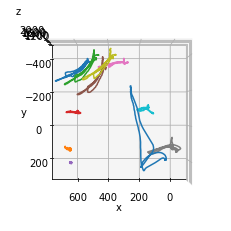

In [15]:
action = "drinking"
plot_action(action,joints,0)

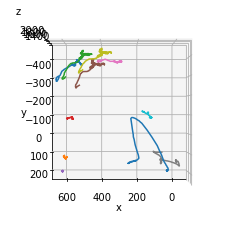

In [16]:
action = "eat_crisp"
plot_action(action,joints,0)

Laversi le mani, aprire e chiudere una bottiglia e giocare con il cubo di rubik:

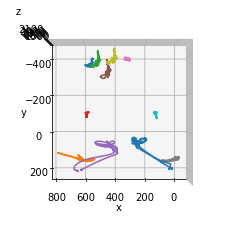

In [17]:
action = "sanitise"
plot_action(action,joints,0)

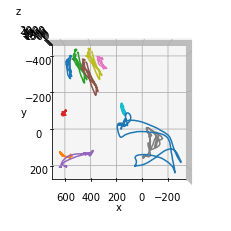

In [18]:
action = "open_close_bottle"
plot_action(action,joints,0)

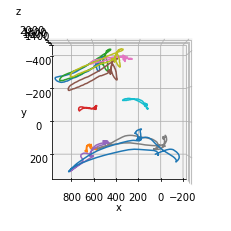

In [19]:
action = "rubiks_cube"
plot_action(action,joints,0)

Da una prima analisi visiva possiamo dire che come ci aspettavamo tutti i giunti del viso tracciano lo stesso disegno nello spazio. Stessa cosa per le spalle, anche se in generale, se la persona ruota la testa o le spalle verso destra o sinistra, la telecamera potrebbe non vedere più i giunti di riferimento e di conseguenza i dati potrebbero subire del rumore. 
I movimenti dei polsi non sono simmetrici fatta esclusione per l'azione di sanitise.

Notiamo subito che qualsiasi sia l'oggetto trasportato la traiettoria del movimento è molto simile per tutti i traporti, anche se varia l'ampiezza.
I muovimenti del viso seguono quello del braccio destro che trasporta l'oggetto.

Notiamo che le azioni di trasporto sono comprese nelle altre azioni, infatti prima di compiere l'azione vera e propria, l'individuo prende l'oggetto necessario per compiere l'azione, e questo provoca rumore nell' analisi del singolo movimento; questa cosa non si nota nell'azione di sanitise, probabilmente perchè l'individuo simula l'azione e non prende effettivamente il gel.

Infine notiamo che per l'individuo 0 il tocco e il trasporto della bottiglia non sono troppo simili, infatti la traiettoria del muovimento è simile ma nel tocco ha un'ampiezza minore; probabilmente questo dipende dalla posizione dell'oggetto sul tavolo rispetto all'individuo.
Per il tocco e il traporto del cubo di rubik per l'individuo 0 notiamo invece una somiglianza più forte, questo probabilmente è dovuto alla posizione dell'oggetto come detto precedentemente per la bottiglia.
Assumendo di prendere gli oggetti con la mano destra, se l'oggetto è alla propria destra il movimento sarà minimo, come forse è accaduto nel tocco della bottiglia, invece se è alla sinistra come forse è stato nel tocco del cubo di rubik il movimento totale è più simile al trasporto.

Le spalle fanno un movimento minimo come ci si poteva aspettare e i gomiti "seguono" il muovimento del relativo polso, quello destro traccia un muovimento simile ma meno ampio e quello sinistro fa movimenti impercettibili come il relativo polso.

# Features

units: meters and seconds

In [20]:
features_df = pd.read_parquet(features).applymap(lambda x: x.astype(np.float16))

### Esplorazione
Vediamo informazioni di base relative al dataset feature

In [21]:
features_df.head(1)

type_feature                                                       displacement  \
data                                                                  positions   
feature                                                        max_displacement   
variable                                                                      x   
joint person action   sample                                                      
lear  0      drinking 0       [0.015, 0.0205, 0.0285, 0.036, 0.044, 0.054, 0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      y   
joint person action   sample                                                      
lear  0      drinking 0       [0.02174, 0.02824, 0.03275, 0.03925, 0.04575, ...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      z   
joint person action   sample                                                      
lear  0      drinking 0       [0.014, 0.017, 0.019, 0.022, 0.024, 0.025, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                              magnitude   
joint person action   sample                                                      
lear  0      drinking 0       [0.0299, 0.03882, 0.0474, 0.05762, 0.0679, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                      total_displacement   
variable                                                                      x   
joint person action   sample                                                      
lear  0      drinking 0       [0.015, 0.02, 0.028, 0.0355, 0.043, 0.053, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      y   
joint person action   sample                                                      
lear  0      drinking 0       [0.01525, 0.02374, 0.02824, 0.03476, 0.0435, 0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      z   
joint person action   sample                                                      
lear  0      drinking 0       [-0.008, -0.013, -0.015, -0.018, -0.022, -0.02...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                              magnitude   
joint person action   sample                                                      
lear  0      drinking 0       [0.02284, 0.03366, 0.0425, 0.05283, 0.065, 0.0...   

type_fea

In [22]:
features_df.shape

(3520, 158)

In [23]:
features_df.dtypes

type_feature  data       feature             variable 
displacement  positions  max_displacement    x            object
                                             y            object
                                             z            object
                                             magnitude    object
                         total_displacement  x            object
                                                           ...  
dynamic       jerk       skewness            magnitude    object
                         kurtosis            x            object
                                             y            object
                                             z            object
                                             magnitude    object
Length: 158, dtype: object

In [24]:
type(features_df.iloc[0, 0])

numpy.ndarray

In [25]:
features_df.iloc[0, 0].dtype

dtype('float16')

**Livelli del dataset**

In [26]:
for i in range(features_df.index.nlevels):
    print(features_df.index.get_level_values(i).unique())

Index(['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear',
       'relbow', 'reye', 'rshoulder', 'rwrist'],
      dtype='object', name='joint')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name='person')
Index(['drinking', 'eat_crisp', 'open_close_bottle', 'rubiks_cube', 'sanitise',
       'touch_bottle', 'touch_rubiks_cube', 'transport_bottle',
       'transport_pen', 'transport_rubiks_cube'],
      dtype='object', name='action')
Int64Index([0, 1, 2], dtype='int64', name='sample')


In [27]:
for i in range(features_df.columns.nlevels):
    print(features_df.columns.get_level_values(i).unique())

Index(['displacement', 'frequency', 'dynamic'], dtype='object', name='type_feature')
Index(['positions', 'velocities', 'acceleration', 'jerk'], dtype='object', name='data')
Index(['max_displacement', 'total_displacement', 'peak_power_density',
       'entropy_power_density', 'sum_power_density', 'maximum',
       'third_quartile', 'second_quartile', 'first_quartile', 'minimum', 'iqr',
       'ptp', 'mean', 'variance', 'standard_deviation', 'skewness',
       'kurtosis'],
      dtype='object', name='feature')
Index(['x', 'y', 'z', 'magnitude'], dtype='object', name='variable')


---

## Correlazione

Secondo le osservazioni fatte sopra provo a formulare le seguenti ipotesi che validerò o meno con il calcolo della correlazione:

* Ci aspettiamo una correlazione alta anche tra le azioni simili:
    - trasporto e tocco del cubo di rubik
    - trasporto e tocco bottiglia
    - bere e mangiare
    - sanitise e aprire bottiglia
    - sanitise e giocare con il cubo di rubik
    - aprire bottiglia e cubo di rubik

**Nota: calcolare correlazione solo con feature di cinematica non di frequenza, non ha senso, forse non hanno senso nemmeno displacement e dynamic**

1.1.: Correlazione tra trasporto e tocco del cubo di rubik 


<AxesSubplot:title={'center':'total displacement tocco cubo di rubik - polso destro'}>

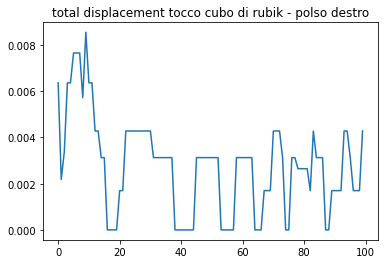

In [110]:
touch_rc_disp = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:100]

touch_rc_disp.plot(title="total displacement tocco cubo di rubik - polso destro")

<AxesSubplot:title={'center':'total displacement trasporto cubo di rubik - polso destro'}>

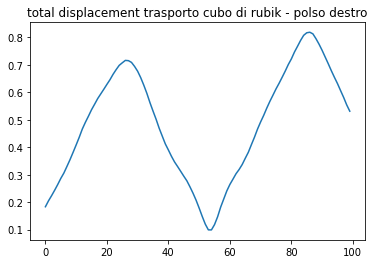

In [111]:
transport_rc_disp = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:100]

transport_rc_disp.plot(title="total displacement trasporto cubo di rubik - polso destro")

In [112]:
np.corrcoef(touch_rc_disp.astype(float),transport_rc_disp.astype(float))

array([[ 1.        , -0.01179343],
       [-0.01179343,  1.        ]])

Non c'è correlazione tra i total displacement dei polsi destri di trasporto e tocco del cubo di rubik

<AxesSubplot:title={'center':'velocità media tocco cubo di rubik - polso destro'}>

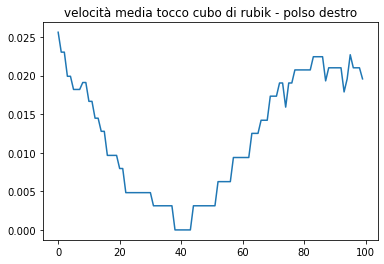

In [118]:
touch_rc_vel = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

touch_rc_vel.plot(title="velocità media tocco cubo di rubik - polso destro")

<AxesSubplot:title={'center':'velocità media trasporto cubo di rubik - polso destro'}>

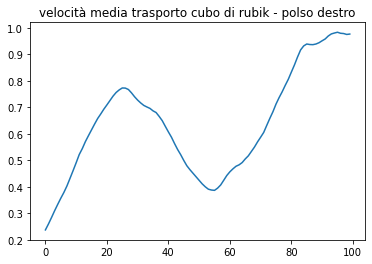

In [119]:
transport_rc_vel = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]

].explode().reset_index(drop=True)[:100]

transport_rc_vel.plot(title="velocità media trasporto cubo di rubik - polso destro")

In [120]:
np.corrcoef(touch_rc_vel.astype(float),transport_rc_vel.astype(float))

array([[1.       , 0.2893575],
       [0.2893575, 1.       ]])

Non c'è correlazione tra le due azioni sotto il punto di vista della velocità media

<AxesSubplot:title={'center':'accelerazione media tocco cubo di rubik - polso destro'}>

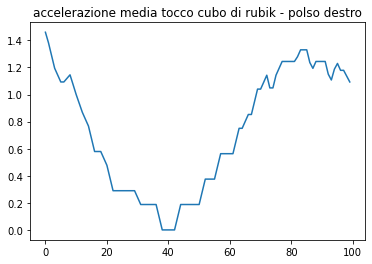

In [121]:
touch_rc_acc = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", [0]],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

touch_rc_acc.plot(title="accelerazione media tocco cubo di rubik - polso destro")

<AxesSubplot:title={'center':'accelerazione media trasporto cubo di rubik - polso destro'}>

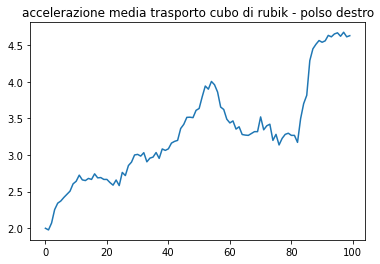

In [122]:
transport_rc_acc = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", [0]],
    idx["dynamic", "acceleration", "mean", "magnitude"]

].explode().reset_index(drop=True)[:100]

transport_rc_acc.plot(title="accelerazione media trasporto cubo di rubik - polso destro")

In [124]:
np.corrcoef(touch_rc_acc.astype(float),transport_rc_acc.astype(float))

array([[1.        , 0.19946077],
       [0.19946077, 1.        ]])

Non c'è correlazione tra le due azioni sotto il punto di vista dell' accelerazione media

<AxesSubplot:title={'center':'accelerazione media tocco cubo di rubik - polso destro'}>

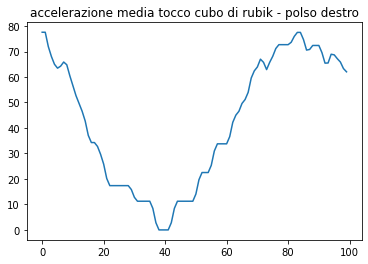

In [126]:
touch_rc_j = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", [0]],
    idx["dynamic", "jerk", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

touch_rc_j.plot(title="accelerazione media tocco cubo di rubik - polso destro")

<AxesSubplot:title={'center':'accelerazione media trasporto cubo di rubik - polso destro'}>

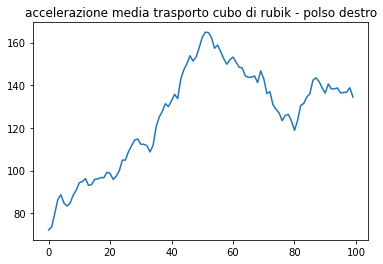

In [127]:
transport_rc_j = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", [0]],
    idx["dynamic", "jerk", "mean", "magnitude"]

].explode().reset_index(drop=True)[:100]

transport_rc_j.plot(title="accelerazione media trasporto cubo di rubik - polso destro")

In [128]:
np.corrcoef(touch_rc_j.astype(float),transport_rc_j.astype(float))

array([[ 1.        , -0.14990019],
       [-0.14990019,  1.        ]])

Non ci sono correlazioni tra i jerk delle due azioni

In generale le due azioni non sono correlate sotto il punto di vista di spostamento e dinamica.

**TODO**: FARE STESSA ANALISI PER LE ALTRE COPPIE DI AZIONI SIMIILI (forse?)

## T-Test

Come abbiamo visto dai grafici dei movimenti, quelli di trasporto e quelli di tocco del cubo di rubik sono molto simili, possiamo fare un test statistico per confermare l'ipotesi. Quindi avremo:

* H0 = l'azione di trasporto è simile a quella di tocco
* HA = l'azione di trasporto è diversa da quella di tocco

Usiamo il t-test per valutare le due ipotesi; in particolare valutiamo le due azioni rispetto alle feature legate al displacement.


Per fare il t-test è necessario prendere un campione rispetto alla popolazione totale, e devono valere le seguenti regole:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.

Inoltre prenderemo come soglie:
* Livello di siginificatività : 0.05
* Livello di confidenza: 95%


Calcolo la popolazione totale

In [79]:
transport_rc = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

transport_rc.shape

(3905,)

In [80]:
touch_rc = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

touch_rc.shape

(3104,)

Quindi in questo caso abbiamo che:
1. n = 310 > 30
2. N è circa 3100

Seleziono il campione dal trasporto del cubo di rubik

In [81]:
a_transport_rc = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:310]

a_transport_rc.shape

(310,)

Uso come popmean la popolazione totale del tocco, e come campione gli elementi selezionati dal trasporto

In [82]:
t_statistic, p_value = stats.ttest_1samp(a= a_transport_rc, popmean= touch_rc.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  -0.2649089960600653
p-value:  0.7912561917969547


Dato che il p-value è maggiore del livello di significatività non posso rigettare l'ipotesi nulla, potremmo accettare l'ipotesi nulla se il p-value fosse >0.95.
Quindi c'è buona probabilità che le due azioni siano simili.

---

* H0 = l'azione di trasporto bottiglia è simile a quella di tocco bottiglia
* HA = l'azione di trasporto bottiglia è diversa da quella di tocco bottiglia


Calcolo la popolazione totale

In [129]:
transport_bot = features_df.loc[
    idx["rwrist", :, "transport_bottle", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

transport_bot.shape

(4342,)

In [132]:
touch_bot = features_df.loc[
    idx["rwrist", :, "touch_bottle", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

touch_bot.shape

(2714,)

Quindi in questo caso abbiamo che:
1. n = 270 > 30
2. N è circa 2700

Seleziono il campione dal trasporto della bottiglia

In [134]:
a_transport_bot = features_df.loc[
    idx["rwrist", :, "transport_bottle", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:270]

a_transport_bot.shape

(270,)

In [135]:
t_statistic, p_value = stats.ttest_1samp(a= a_transport_bot, popmean= touch_bot.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  9.874384459087267
p-value:  7.999320884428636e-20


Dato che il p-value è minore del livello di significatività quindi rigetto l'ipotesi nulla in favore di quella alternativa; le due azioni sono diverse.

---

* H0 = l'azione di sanitise è simile a quella di giocare con il cubo di rubik
* HA = l'azione di sanitise è diversa da quella di giocare con il cubo di rubik


Calcolo la popolazione totale


In [138]:
sanitise = features_df.loc[
    idx[:, :, "sanitise", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

sanitise.shape

(59444,)

In [159]:
rc = features_df.loc[
    idx[:, :, "rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

rc.shape

(92444,)

Quindi in questo caso abbiamo che:
1. n = 5800 > 30
2. N è circa 58000

Seleziono il campione da sanitise

In [145]:
a_sanitise = features_df.loc[
    idx[:, :, "sanitise", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:58000]

a_sanitise.shape

(58000,)

In [158]:
a_obc = features_df.loc[
    idx[:, :, "open_close_bottle", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:58000]

a_ocb.shape

(92000,)

In [161]:
a_rc = features_df.loc[
    idx[:, :, "rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:58000]

a_rc.shape

(58000,)

In [162]:
t_statistic, p_value = stats.ttest_1samp(a= a_rc, popmean= sanitise.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  5.405739623323523
p-value:  6.479551872340541e-08


Dato che il p-value è minore del livello di significatività rigetto l'ipotesi nulla in favore di quella alternativa; le due azioni sono diverse.

---

* H0 = l'azione di sanitise è simile a quella di aprire e chiudere la bottiglia
* HA = l'azione di sanitise è diversa da quella di aprire e chiudere la bottiglia


Calcolo la popolazione totale


In [150]:
ocb = features_df.loc[
    idx[:, :, "open_close_bottle", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

ocb.shape

(95953,)

Quindi in questo caso abbiamo che:
1. n = 5800 > 30
2. N è circa 58000

In [163]:
t_statistic, p_value = stats.ttest_1samp(a= a_ocb, popmean= sanitise.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  9.230420768285047
p-value:  2.7506449742475e-20


Dato che il p-value è minore del livello di significatività rigetto l'ipotesi nulla in favore di quella alternativa; le due azioni sono diverse.

---

* H0 = l'azione di giocare con il cubo di rubik è simile a quella di aprire e chiudere la bottiglia
* HA = l'azione di giocare con il cubo di rubik è diversa da quella di aprire e chiudere la bottiglia


Calcolo la popolazione totale


Abbiamo già calcolato le varie popolazioni totali quindi abbiamo che:
1. n = 9200 > 30
2. N è circa 92000

Seleziono il campione da rubiks_cube

In [164]:
a_rb = features_df.loc[
    idx[:, :, "rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:92000]

a_rb.shape

(92000,)

In [165]:
a_ocb = features_df.loc[
    idx[:, :, "open_close_bottle", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:92000]

a_rb.shape

(92000,)

In [166]:
t_statistic, p_value = stats.ttest_1samp(a= a_rb, popmean= ocb.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  3.344926029390085
p-value:  0.0008233739778626945


In [167]:
t_statistic, p_value = stats.ttest_1samp(a= a_ocb, popmean= rb.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  -2.146212660461362
p-value:  0.03185862339690476


considerando il cubo di rubik come popolazione media non possiamo rigettare l'ipotesi nulla, invece considerando open_close_bottle come popolazione media rigettiamo l'ipotesi nulla in favore di quella alternativa, quindi concludiamo che le due azioni sono differenti

---

* H0 = l'azione di mangiare patatine è simile a quella di bere
* HA = l'azione di mangiare è diversa da quella di bere

Calcolo la popolazione totale


In [173]:
ec = features_df.loc[
    idx[:, :, "eat_crisp", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

ec.shape

(48983,)

In [174]:
d = features_df.loc[
    idx[:, :, "drinking", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

d.shape

(65956,)

Quindi in questo caso abbiamo che:
1. n = 4898 > 30
2. N è circa 48980

Seleziono il campione da mangiare patatine

In [178]:
a_ec = features_df.loc[
    idx[:, :, "eat_crisp", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:48980]

a_ec.shape

(48980,)

In [179]:
t_statistic, p_value = stats.ttest_1samp(a= a_ec, popmean= d.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  -11.36112537257292
p-value:  7.117644113818117e-30


Rigetto l'ipotesi nulla in favore di quella alternativa, le due azioni sono diverse

---

**TODO**: fare test statistici per verificare somiglianza tra:
- trasporto e tocco bottiglia (v)
- sanitise e rubiks_cube, sanitise e open_close_bottle, rubiks_cube e open_close_bottle (v)
- eat_crisp e drinking(v)

ok
---

## Regressione Logistica - ML supervisionato

Possiamo usare un algoritmo di regressione logistica per classificare se un'azione è relativa al trasporto o al tocco del cubo di rubik

Passi da seguire:

1. Dividere dataset in training e test;
2. Istanziare un oggetto della classe LogisticRegression;
3. Fare fit su training set;
4. Usare la funzione score che fornisce l'accuratezza intesa come numero di volte in cui abbiamo predetto correttamente la classe rispetto al totale. 

In [89]:
# funzione che divide il data set in train e test

def my_train_test_slipt(X, joints, actions):
    n_features = X.columns.size
    n_joints = len(joints)
    n_people = 16
    n_actions = len(actions)
    n_samples = 50

    tr = np.asarray(X.loc[idx[joints, :, actions, 0]].reset_index(drop=True))
    te = np.asarray(X.loc[idx[joints, :, actions, 1]].reset_index(drop=True))
    y_train = np.asarray(X.loc[idx[joints, :, actions, 0]].reset_index()['action'])
    y_test = np.asarray(X.loc[idx[joints, :, actions, 1]].reset_index()['action'])

    y_train_fixed = np.zeros(shape=(n_samples * n_people * n_actions), dtype=(np.unicode_, 16))
    y_test_fixed = np.zeros(shape=(n_samples * n_people * n_actions), dtype=(np.unicode_, 16))
    X_train = np.zeros((n_people * n_actions, n_features * n_joints, n_samples), dtype=np.float64)
    X_test = np.zeros((n_people * n_actions, n_features * n_joints, n_samples), dtype=np.float64)

    for z in range(n_people * n_actions):
        for k in range(n_joints):
            for j in range(n_features):
                for i in range(n_samples):
                    X_train[z, j + (n_joints - 1), i] = tr[z + k * (n_joints - 1)][j][-i]
        for i in range(n_samples):
            y_train_fixed[z * n_samples + i] = y_train[z]

    for z in range(n_people * n_actions):
        for k in range(n_joints):
            for j in range(n_features):
                for i in range(n_samples):
                    X_test[z, j + (n_joints - 1), i] = te[z + k * (n_joints - 1)][j][-i]
        for i in range(n_samples):
            y_test_fixed[z * n_samples + i] = y_test[z]

    X_train = X_train.reshape(-1, n_features * n_joints)
    X_test = X_test.reshape(-1, n_features * n_joints)

    if np.where(y_train_fixed == ''):
        return X_train, X_test, y_train_fixed, y_test_fixed
    else : 
        print("Ci sono degli elementi nulli")

Calcolo la regressione logistica prendendo tutti i joints e tutte le feature della categoria displacement

In [90]:
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear','relbow', 'reye', 'rshoulder', 'rwrist']

actions = ['transport_rubiks_cube', 'touch_rubiks_cube']

X = features_df.loc[idx[joints, :, actions, :],idx[['displacement']]]

X_train,X_test,y_train_fixed,y_test_fixed = my_train_test_slipt(X, joints, actions)

In [91]:
regressor = LogisticRegression()

regressor.fit(X_train,y_train_fixed)
regressor.score(X_test,y_test_fixed)


0.513125

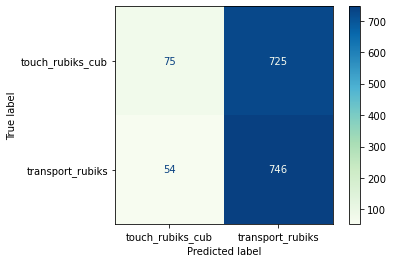

In [92]:

ConfusionMatrixDisplay.from_estimator(regressor, X_test, y_test_fixed, cmap='GnBu')

Il risultato che abbiamo ottenuto dalla regressione logistica di trasporto e tocco del cubo di rubik non è soddisfacente, ma era prevedibile in quanto dal ttest fatto in precedenza risultava che le due azioni sono simili, quindi è normale che l'algoritmo non riesca a classificarle correttamente.

Se avessimo classificato le azioni in modo casuale avremmo ottenuto un regressor score simile che si aggira intorno allo 0.5 come nel nostro caso.

La confusion matrix ha sulla sua diagonale i valori classificati correttamente, quindi avremmo ottenuto un risultato ottimale se la diagonale fosse stata blu scuro (tanti valori sarebbero stati classificati correttamente); invece osservando la matrice emerge che molte delle tuple associate all'azione di trasport sono state classificate correttamente, ma la maggior parte delle tuple relative al tocco sono state classificate erroneamente.

**TODO: rifare lo stessso per le altre coppie di azioni simili**, se dal test statistico risulta che le due azioni non sono simili, ci aspettiamo che la regressione logistica classifichi bene le due azioni, in caso contrario, ovvero se le due azioni sono simili, fare la regressione logistica darà risultati pessimi e questo dovrebbe servire come ulteriore conferma del fatto che le due azioni sono simili e quindi difficili da distinguere una dall'altra

---

Usiamo ora un algoritmo di regressione logistica per classificare un movimento in base alle tre azioni di trasporto: bottiglia, cubo di rubik e penna (no PF)

In questo caso prendo solo il polso destro come joint e le feature di max_displacement sulla magnitude

In [93]:
joints = ['rwrist']
actions = ['transport_bottle', 'transport_rubiks_cube', 'transport_pen']

X = features_df.loc[idx[joints, :, actions, :],idx['displacement', 'positions', 'max_displacement', ['magnitude']]]

X_train,X_test,y_train_fixed,y_test_fixed = my_train_test_slipt(X, joints, actions)

In [94]:
regressor = LogisticRegression()

regressor.fit(X_train,y_train_fixed)
regressor.score(X_test,y_test_fixed)


0.37375

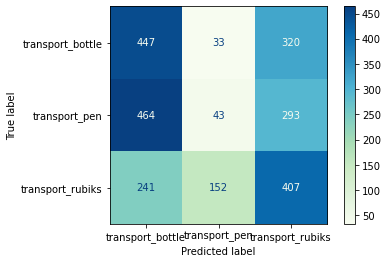

In [95]:
ConfusionMatrixDisplay.from_estimator(regressor, X_test, y_test_fixed, cmap='GnBu')

Anche in questo caso l'algoritmo ha difficoltà a classificare le varie azioni nelle tre categorie, in questo caso è meno giustificato in quanto dal ttest risultava che le azioni non sono simili dal punto di vista del displacement.

Dalla confusion matrix notiamo che vengono classficate meglio le tuple relative al trasporto della bottiglia a scendere quelle del trasporto del cubo di rubik e infine, solo pochissime tuple del trasporto della penna sono state classificate correttamente. 

Spicca una casella molto scura che incrocia trasporto penna e bottiglia; questo significa che è un falso negativo.

Nonostante lo score sia basso, le osservazioni fatte sulla confusion matrix sono coerenti con quanto visto nei ttest, infatti il trasporto bottiglia è quello che è stato classificato meglio, infatti differiva dalle altre due azioni.



## KMeans - ML non supervisionato 

Ora provo a clusterizzare il dataset con kmeans dividendolo nelle due azioni di trasporto e tocco del cubo di rubik; in questo modo posso osservare la differenza tra approccio supervisionato e non.

Considero tutti i joints e tutte le feature della categoria displacement come fatto per la regressione logistica

In [96]:
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear','relbow', 'reye', 'rshoulder', 'rwrist']

actions = ['transport_rubiks_cube', 'touch_rubiks_cube']

X1 = features_df.loc[idx[joints, :, actions, :],idx[['displacement']]]

n_features = X1.columns.size
n_joints = len(joints)
n_people = 16
n_actions = len(actions)
n_samples = 50


l = np.asarray(X1.loc[idx[joints, :, actions]].reset_index(drop=True))

X1 = np.zeros((n_people * n_actions * n_joints, n_features, n_samples), dtype=np.float64)

for z in range(len(X1)):
    for j in range(len(l[z])):
        for i in range(n_samples):
            X1[z, j, i] = l[z][j][i]
            
         
X1 = X1.reshape(-1, n_features)

scaler = preprocessing.StandardScaler().fit(X1)

X1 = scaler.transform(X1)



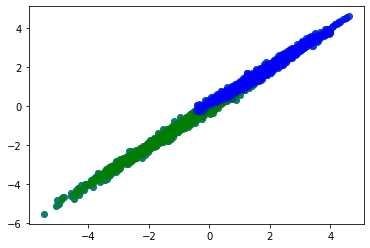

In [97]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X1)
y = kmeans.labels_
plt.scatter(X1[:,0],X1[:,1])
color = ['g','b']

for i in range(0,2):
    plt.scatter(X1[np.where(y==i),0],X1[np.where(y==i),1],color=color[i],alpha=0.3)


Per visualizzare meglio quanto ottenuto uso PCA

In [98]:
pca = decomposition.PCA(n_components=2)

In [99]:
X_pca = pca.fit_transform(X1)
print(X_pca.shape)


(17600, 2)


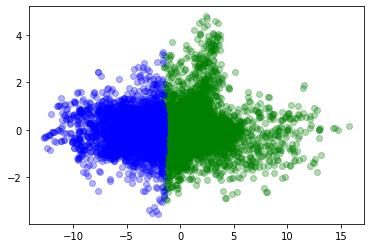

In [100]:
for i in range(0,2):
    plt.scatter(X_pca[np.where(y==i),0],X_pca[np.where(y==i),1],color=color[i],alpha=0.3)

Per capire la correttezza misuriamo l'indice di silhouette

In [101]:
from sklearn.metrics import silhouette_samples, silhouette_score
def silhouette(x):
    silhouette_avg = []
    for i in range(2, 16):
        kmeans = KMeans(n_clusters = i, max_iter = 20, random_state = 0)
        cluster_labels = kmeans.fit_predict(x)
        silhouette_avg.append(silhouette_score(x, cluster_labels))
    
    plt.plot(range(2, 16), silhouette_avg,'-o')
    plt.title('The silhouette method')
    plt.xlabel('Number of clusters')
    plt.ylabel('silhouette coefficient') #within cluster sum of squares
    plt.show()

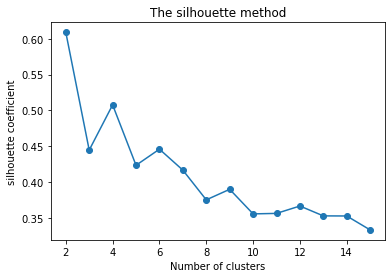

In [102]:
silhouette(X1)

Dal grafico risulta che il miglior indice di silhouette ottenibile è dividendo in due cluster.

**TODO: ripetere test per le altre coppie di azioni simili**

---
Ora provo a clusterizzare il dataset in base alle persone nel compiere l'azione di trasporto cubo di rubik, quindi usando 16 cluster.
Considero il polso destro e il naso per avere un riferimento del viso come joints e come feature uso il max displacement di x, y e z
(no PF)

In [103]:
joints = ['rwrist', 'nose']
actions = ['transport_rubiks_cube']

X2 = features_df.loc[idx[joints, :, actions, :], idx['displacement', 'positions', 'max_displacement', ['x', 'y', 'z']]]

n_features = X2.columns.size
n_joints = len(joints)
n_people = 16
n_actions = len(actions)
n_samples = 50

l2 = np.asarray(X2.loc[idx[joints, :, actions]].reset_index(drop=True))

X2 = np.zeros((n_people * n_actions * n_joints, n_features, n_samples), dtype=np.float64)

for z in range(len(X2)):
    for j in range(len(l2[z])):
        for i in range(n_samples):
            X2[z, j, i] = l2[z][j][i]

X2 = X2.reshape(-1, n_features)

scaler = preprocessing.StandardScaler().fit(X2)

X2 = scaler.transform(X2)

kmeans = KMeans(n_clusters=16, random_state=0).fit(X2)


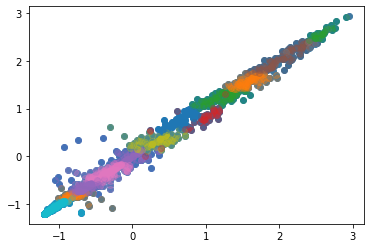

In [104]:
y = kmeans.labels_
plt.scatter(X2[:,0],X2[:,1])


for i in range(0,16):
    plt.scatter(X2[np.where(y==i),0],X2[np.where(y==i),1],alpha=0.3)

In [105]:
pca = decomposition.PCA(n_components=2)

In [106]:
X_pca = pca.fit_transform(X2)
print(X_pca.shape)


(1600, 2)


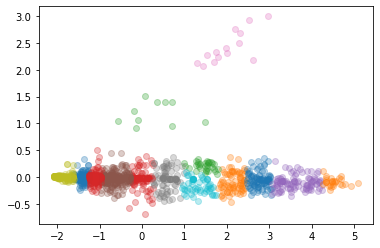

In [107]:
for i in range(0,16):
    plt.scatter(X_pca[np.where(y==i),0],X_pca[np.where(y==i),1],alpha=0.3)

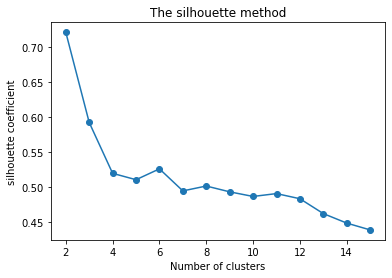

In [108]:
silhouette(X2)

In questo caso il numero di cluster in cui ho suddiviso non è coerente con il grafico di silhouette ottenuto.
Quindi il risultato ottenuto non è significativo

**TODO: aggiungere analisi della distrubuzione della velocità(e altre feature), e confrontarle tra azioni simili**

**TODO: visualizzazione con spider web(???????????)**

# Conclusioni

Rispetto all'analisi dei dati svolta, posso dire che la correlazione tra le varie azioni di trasporto è molto alta dal punto di vista della frequenza e vale la stessa cosa per la correlazione di trasporto e tocco del cubo di rubik.

Una scoperta interessante è data dal t-test in quanto risultano molto più simili tra loro le azioni di trasporto e tocco del cubo di rubik piutto che le varie azioni di trasporto, fatta eccezione per trasporto penna e trasporto cubo di rubik che hanno un p-value lievemente maggiore del livello di significatività.

Per quanto riguarda la classificazione con regressione logistica tra azioni di trasporto e tocco del cubo di rubik non si arriva a buoni risultati, ma questo potrebbe essere dovuto al fatto che risultino simili dal t-test. Mentre la regresssione logistica fatta per classificare le varie azioni di trasporto (bottiglia, tocco, cubo di rubik) da cui ci aspettavamo buoni risultati in quanto dal t-test queste azioni sono considerate distinte, da inspiegabilmente pessimi risultati, anche più deludenti rispetto alla precedente, infatti il regression score è minore del 50%.

Infine per quanto riguarda la clusterizzazione con kmeans riproponendo come cluster trasporto e tocco del cubo di rubik otteniamo che secondo l'indice di silhouette è corretto usare due cluster. Mentre la seconda clusterizzazione che divide in base alle persone, non da buoni risultati rispetto allo stesso indice.